In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


# Generate dataset

0 522
1 501
2 477
3 3500


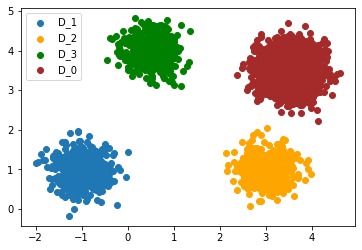

In [3]:
np.random.seed(12)
y = np.random.randint(0,3,1500)
y1 = np.random.randint(3,4,3500)
y = np.hstack((y,y1))
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)
x = np.zeros((5000,2))
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [-1,1],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [3,1],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [0.5,4],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3.5,3.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))


color = ['#1F77B4','orange', 'g','brown']
name = [1,2,3,0]
for i in range(4):
  if i==3:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3],label="D_"+str(name[i]))
  elif i>=4:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[i],label="D_"+str(name[i]))
plt.legend()

# Calculate Margin using linear svm

0.02126656427634795


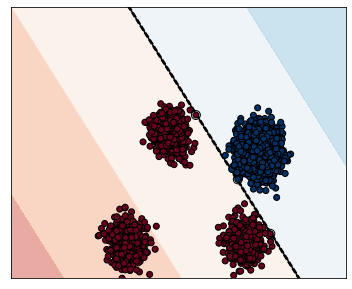

In [4]:
from sklearn import svm
from matplotlib import cm

idx_ = np.logical_or(np.logical_or(y==0,y==1),y==2) 
Y_ = np.zeros(5000)
Y_[~idx_] = 1 
X_ = x


clf = svm.SVC(kernel='linear', C=1e10)
clf.fit(X_, Y_)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]

xx = np.linspace(-7, 7)
yy = a * xx - (clf.intercept_[0]) / w[1]


# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
print(margin)

yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(1, figsize=(6, 5))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')

plt.plot(xx, yy_up, 'k--')
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10, edgecolors='k',
            cmap=cm.get_cmap('RdBu'))
plt.scatter(X_[:, 0], X_[:, 1], c=Y_, zorder=10, cmap=cm.get_cmap('RdBu'),
            edgecolors='k')

plt.axis('tight')
x_min = -5
x_max = 6.5
y_min = 0
y_max = 7.5

YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Put the result into a contour plot
plt.contourf(XX, YY, Z, cmap=cm.get_cmap('RdBu'),
              alpha=0.5, linestyles=['-'])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())


plt.show()


# plt.scatter(X_[Y_==0,0],X_[Y_==0,1],c=color[0],label="D_"+str(name[i]))

# plt.scatter(X_[Y_==1,0],X_[Y_==1,1],c=color[3],label="D_"+str(name[i]))



Text(0, 0.5, 'X2')

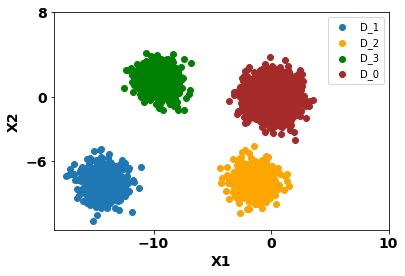

In [5]:
bg_idx = [ np.where(idx[3] == True)[0], ]

bg_idx = np.concatenate(bg_idx, axis = 0)
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)
color = ['#1F77B4','orange', 'g','brown']
for i in range(4):
  if i==3:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3],label="D_"+str(name[i]))
  elif i>=4:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[i],label="D_"+str(name[i]))
plt.legend()
plt.xticks([-10, 0, 10], fontsize=14, fontweight = 'bold')
plt.yticks([-6, 0, 8], fontsize=14, fontweight = 'bold')
plt.xlabel("X1", fontsize=14, fontweight = 'bold')
plt.ylabel("X2" , fontsize=14, fontweight = 'bold')
# plt.savefig(fp_cin+"ds2_data.png", bbox_inches="tight")
# plt.savefig(fp_cin+"ds2_data.pdf", bbox_inches="tight")

In [6]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3'}

In [7]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    #print("fg class",fg_class)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            #print("bg_class",bg_class)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(9,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [8]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


mosaic_list_of_images = np.stack(mosaic_list_of_images)

mosaic_list_of_images[0],


(array([[-13.32311566,  -9.11995738],
        [ -2.00169761,   0.19592321],
        [  0.13912769,   0.55569986],
        [ -0.33755978,  -0.67411856],
        [ -1.75554162,   0.43329245],
        [  0.51856397,   0.16906796],
        [  0.25589861,  -0.16270148],
        [ -1.69019131,   0.5946991 ],
        [ -1.68730674,   1.10656791]]),)

In [9]:
# mean_ = np.mean(mosaic_list_of_images[0:1000],axis=0,keepdims=True)
# std_ = np.std(mosaic_list_of_images[0:1000],axis=0,keepdims=True)

# mosaic_list_of_images = (mosaic_list_of_images - mean_)/std_
mosaic_list_of_images = np.reshape(mosaic_list_of_images,(2000,18))

In [10]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((2000, 18), array([-13.32311566,  -9.11995738,  -2.00169761,   0.19592321,
          0.13912769,   0.55569986,  -0.33755978,  -0.67411856,
         -1.75554162,   0.43329245,   0.51856397,   0.16906796,
          0.25589861,  -0.16270148,  -1.69019131,   0.5946991 ,
         -1.68730674,   1.10656791]))

In [11]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [12]:
batch = 1000
msd1 = MosaicDataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000] , fore_idx[0:1000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [13]:
batch = 1000
msd2 = MosaicDataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000] , fore_idx[1000:2000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [14]:
class Focus(nn.Module):
  def __init__(self):
      super(Focus,self).__init__()
      self.fc1 = nn.Linear(2,1)

  def forward(self,z):
      x = torch.zeros([batch,9],dtype=torch.float64)
      y = torch.zeros([batch,2], dtype=torch.float64)
      x,y = x.to("cuda"),y.to("cuda")
      for i in range(9):
          x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
          #print(k[:,0].shape,x[:,i].shape)
      x = F.softmax(x,dim=1)   # alphas
      x1 = x[:,0]
      for i in range(9):
          x1 = x[:,i]          
          #print()
          y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
      # print(y.shape, x.shape)
      return x , y
    
  def helper(self, x):
    x = x.view(-1, 2)
    # x = F.relu(self.fc1(x))
    x = (self.fc1(x))

    return x

In [15]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 3)


  def forward(self, x):
    x = x.view(-1, 2)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [16]:
import torch.optim as optim

def train(train_loader, test_loader, focus_net, classify):    
  criterion = nn.CrossEntropyLoss()
  optimizer_classify = optim.SGD(classify.parameters(), lr=0.01 , momentum=0.9)
  optimizer_focus = optim.SGD(focus_net.parameters(), lr=0.01, momentum=0.9)

  print('-'*50)
  print(focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias)
  nos_epochs = 1000
  loss_ret=0.0
  for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    epoch_loss = []
    cnt=0

    iteration = desired_num // batch
    
    #training data set
    
    for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
      inputs = inputs.double()
      labels = labels
      # zero the parameter gradients
      
      optimizer_focus.zero_grad()
      optimizer_classify.zero_grad()
      
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)

      _,predicted = torch.max(outputs.data, 1)
      # print(predicted)
      # print(outputs.shape,labels.shape)
      # print(outputs)
      # print(labels)
      loss = criterion(outputs, labels) 
      loss.backward()
      optimizer_focus.step()
      optimizer_classify.step()

      running_loss += loss.item()
      # mini = 3
      # if cnt % mini == mini-1 :    # print every 40 mini-batches
      epoch_loss.append(running_loss)
      running_loss = 0.0
      cnt=cnt+1
    loss_ret = np.mean(epoch_loss)
    if(epoch%200==0):
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, np.mean(epoch_loss)))
    if(np.mean(epoch_loss) <= 0.001):
        break;

  with torch.no_grad():
    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0
    for data in test_loader:
      inputs, labels , fore_idx = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)
      _,predicted = torch.max(outputs.data, 1)

      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        # print(focus, fore_idx[j], predicted[j], labels[j])
        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  print('Finished Training')  
  return loss_ret, argmax_more_than_half/10, focus_true_pred_true/10, focus_false_pred_true/10, focus_true_pred_false/10 , focus_false_pred_false/10, focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias
    


In [17]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[0.0, 0.0]])))
torch.manual_seed(12)
classify = Classification().double()
classify.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0] ])))
classify.fc1.bias = torch.nn.Parameter(torch.tensor(np.array([0.0, 0.0, 0.0])))
focus_net = focus_net.to("cuda")
classify = classify.to("cuda")
# print("--"*40,"a,b,c = ",a[i],b[j],c[k])
print(focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias)

Parameter containing:
tensor([[0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([0., 0., 0.], device='cuda:0', dtype=torch.float64, requires_grad=True)


In [18]:
cost, alpha_per, ftpt, ffpt, ftpf, ffpf, f_a, f_b, f_c = train(train_loader, test_loader, focus_net, classify)

--------------------------------------------------
Parameter containing:
tensor([[0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([0., 0., 0.], device='cuda:0', dtype=torch.float64, requires_grad=True)
[1,     2] loss: 1.099
[201,     2] loss: 0.008
[401,     2] loss: 0.005
[601,     2] loss: 0.004
[801,     2] loss: 0.003
Finished Training


In [19]:
cost, alpha_per, ftpt, ffpt, ftpf, ffpf, f_a, f_b, f_c

(0.00244992790566648, 100.0, 100.0, 0.0, 0.0, 0.0, Parameter containing:
 tensor([[-0.8963, -0.7067]], device='cuda:0', dtype=torch.float64,
        requires_grad=True), Parameter containing:
 tensor([[-0.2846, -0.2525],
         [ 1.0105, -1.4098],
         [-0.7259,  1.6624]], device='cuda:0', dtype=torch.float64,
        requires_grad=True), Parameter containing:
 tensor([-0.5226,  0.3213,  0.2013], device='cuda:0', dtype=torch.float64,
        requires_grad=True))

2.295644324473828


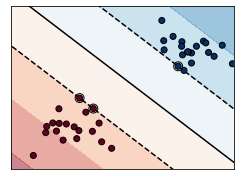

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from sklearn import svm

# # we create 40 separable points
# np.random.seed(0)
# X = np.r_[np.random.randn(20, 2) - [3, 3], np.random.randn(20, 2) + [3, 3]]
# Y = [0] * 20 + [1] * 20

# # figure number
# fignum = 1

# # fit the model
# # for name, penalty in (('unreg', 1), ('reg', 0.05)):

# clf = svm.SVC(kernel='linear', C=1)
# clf.fit(X, Y)

# # get the separating hyperplane
# w = clf.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(-5, 5)
# yy = a * xx - (clf.intercept_[0]) / w[1]

# # plot the parallels to the separating hyperplane that pass through the
# # support vectors (margin away from hyperplane in direction
# # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# # 2-d.
# margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
# print(margin)
# yy_down = yy - np.sqrt(1 + a ** 2) * margin
# yy_up = yy + np.sqrt(1 + a ** 2) * margin

# # plot the line, the points, and the nearest vectors to the plane
# plt.figure(fignum, figsize=(4, 3))
# plt.clf()
# plt.plot(xx, yy, 'k-')
# plt.plot(xx, yy_down, 'k--')

# plt.plot(xx, yy_up, 'k--')
# plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
#             facecolors='none', zorder=10, edgecolors='k',
#             cmap=cm.get_cmap('RdBu'))
# plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=cm.get_cmap('RdBu'),
#             edgecolors='k')

# plt.axis('tight')
# x_min = -4.8
# x_max = 4.2
# y_min = -6
# y_max = 6

# YY, XX = np.meshgrid(yy, xx)
# xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Z = clf.decision_function(xy).reshape(XX.shape)

# # Put the result into a contour plot
# plt.contourf(XX, YY, Z, cmap=cm.get_cmap('RdBu'),
#               alpha=0.5, linestyles=['-'])

# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)

# plt.xticks(())
# plt.yticks(())
# # fignum = fignum + 1a

# plt.show()